In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import datetime
import scipy as sp

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Importing dataset:

In [2]:
MMSI636092331 = pd.read_csv(r"MMSI636092331.csv")
MMSI636092331

,mmsi,lat,long,sog,rot,cog,datetimestamp
0,636092331,-4.767917,48.766190,12.2,15,61.0,2016-03-03 10:58:24
1,636092331,-4.835128,48.742413,13.1,-27,68.5,2016-03-03 10:43:54
2,636092331,-4.835327,48.742360,12.8,-29,68.3,2016-03-03 10:43:53
3,636092331,-4.835595,48.742290,12.4,-37,67.1,2016-03-03 10:43:48
4,636092331,-4.836520,48.742012,12.8,-19,61.4,2016-03-03 10:43:38
...,...,...,...,...,...,...,...
6245,636092331,-5.127655,48.122654,13.3,28,76.4,2016-03-02 04:53:52
6246,636092331,-5.128298,48.122547,13.1,36,74.6,2016-03-02 04:53:46
6247,636092331,-5.128785,48.122480,13.6,-14,71.4,2016-03-02 04:53:40
6248,636092331,-5.129277,48.122353,13.8,34,72.9,2016-03-02 04:53:34


# Converting types:

In [3]:
MMSI636092331['datetimestamp'] = pd.to_datetime(MMSI636092331['datetimestamp'])
#MMSI636092331.sort('datetimestamp')
df_sorted = copy.deepcopy(MMSI636092331.sort_values(by = 'datetimestamp', ascending = True ))


myresult = df_sorted['datetimestamp'] -pd.to_datetime('2016-03-02 03:33:34')
myresult.dt.total_seconds()





df_sorted['datetimestamp'] = pd.DataFrame(myresult.dt.total_seconds())
#print(df_sorted.head())



In [4]:
def convert_cog(data_in):
    return data_in*np.pi/180 #convert to radians

In [5]:
def convert_rot(data_in):
    return (data_in/60)*np.pi/180 #rad per second
    

In [6]:
def convert_sog(data_in):
    return data_in*0.5144444444 #meter per second

In [7]:
def convert_XY(data_in):
    #constants:
    a = 6378137.0
    b = 6356752.3
    
    lat = data_in['lat']
    long = data_in['long']
    def calc_N(a,b,lat):
        e = (a**2 -b**2)/a**2
        return a*(np.sqrt(1-e*np.sin(lat)**2))
    h = 0
    N = calc_N(a,b,lat)
    X = (N+h)*np.cos(lat)*np.cos(long)
    Y = (N+h)*np.cos(lat)*np.sin(long)
    
    

In [8]:
def convert_dataset(data_in):
    #Converting time date:
    df_sorted = copy.deepcopy(data_in.sort_values(by = 'datetimestamp', ascending = True ))
    first_obs_date = df_sorted.iloc[0,6]
    
    #Calculating the time difference in seconds
    time_from_zero_sec = (df_sorted['datetimestamp'] -pd.to_datetime(first_obs_date)).dt.total_seconds()
    df_sorted['datetimestamp'] = pd.DataFrame(time_from_zero_sec)

    #Conversion of Course over ground
    df_sorted['cog'] = convert_cog(df_sorted['cog'])
    
    #Convert Speed over ground to mps
    df_sorted['sog'] = convert_sog(df_sorted['sog'])
    
    #Convert rate of turn 
    df_sorted['rot'] = convert_rot(df_sorted['rot'])
    
    #Making the order same as testset
    
    df_sorted = df_sorted[['datetimestamp', 'lat', 'long', 'cog', 'sog','rot']]
    
    #Adding delta time and updating the order again
    delta_time = [0]
    for i in range(1, len(df_sorted['datetimestamp'])):
        delta_time.append(int(df_sorted['datetimestamp'][i-1]-df_sorted['datetimestamp'][i]))
        
    df_sorted.insert(1,'deltatime',delta_time ) #adding the delta time row

   
    return df_sorted
    
    

In [9]:
def discrete_subsample_data(data_in, eachObs = 10):
    sub_script = np.arange(0,len(data_in),eachObs)
    return data_in.iloc[sub_script,:]
    
    

In [10]:
pd_final=  copy.deepcopy(convert_dataset(MMSI636092331).reset_index(drop = True))


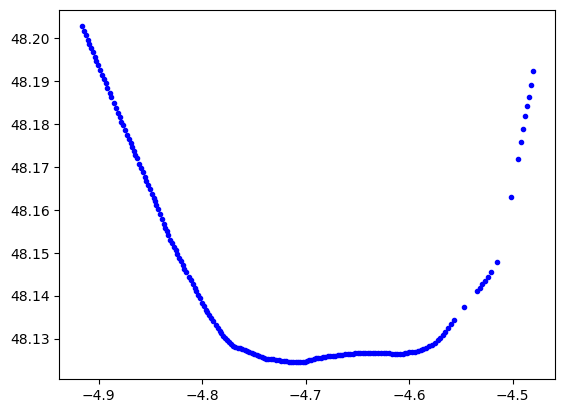

In [11]:
data_out = discrete_subsample_data(MMSI636092331,1)
df_final = data_out.iloc[np.arange(int(len(data_out)*0.25),int(len(data_out)*0.40),5),:]
plt.plot(df_final['lat'],df_final['long'],'b.')
plt.show()

# Testing Kalman

In [12]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

def calc_a_xy(arr_in, arr_prev):
    
    sog_now = arr_in[5]
    sog_prev = arr_prev[5]
    
    cog_now = arr_in[4]*np.pi/180
    cog_prev = arr_prev[4]*np.pi/180
    
    rot_now = arr_in[6]*np.pi/180
    
    delta_time = arr_in[1]
    
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time
    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y
    

In [13]:
def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]
    
    x = arr_in[2]
    y = arr_in[3]
    Vx = sog*np.cos(deg_to_rad(cog))
    Vy = sog*np.sin(deg_to_rad(cog))
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

In [14]:
def extract_long_lat_covariance(mat_in):
    Var1 = mat_in[0,0]
    Var2 = mat_in[1,1]
    Cov12 = mat_in[0,1]
    
    result = np.array([[Var1,Cov12],[Cov12,Var2]])
    return result

In [15]:
data_out_test = discrete_subsample_data(MMSI636092331,4)
var_lat = sp.var(data_out_test['lat'])
var_long = sp.var(data_out_test['long'])
covar = sp.cov(data_out_test['lat'],data_out_test['long'])[0][1]
print('varlat',var_lat)
print('varlong',var_long)
print('covar:', covar)

varlat 0.03978083746330763
varlong 0.003926866078782877
covar: 0.0027159522423034


/home/18974139/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.var is deprecated and will be removed in SciPy 2.0.0, use numpy.var instead
  
/home/18974139/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.var is deprecated and will be removed in SciPy 2.0.0, use numpy.var instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/18974139/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.cov is deprecated and will be removed in SciPy 2.0.0, use numpy.cov instead
  after removing the cwd from sys.path.


pk.val: 1e-07


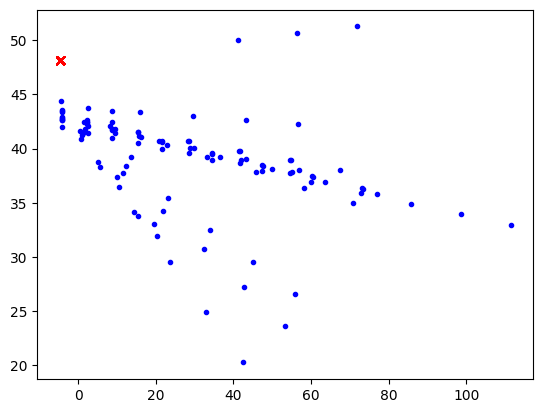

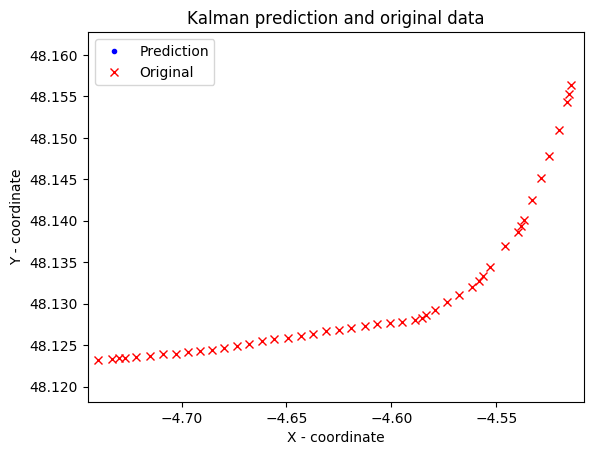

pk.val: 2e-07


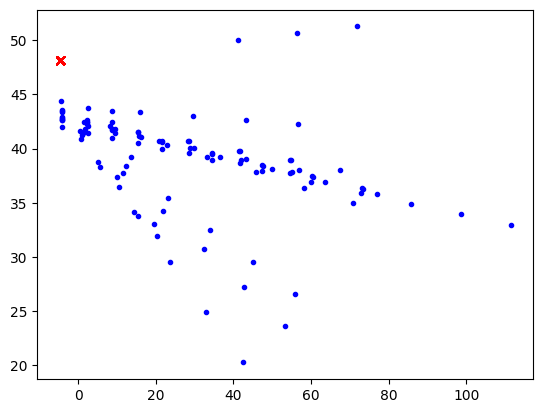

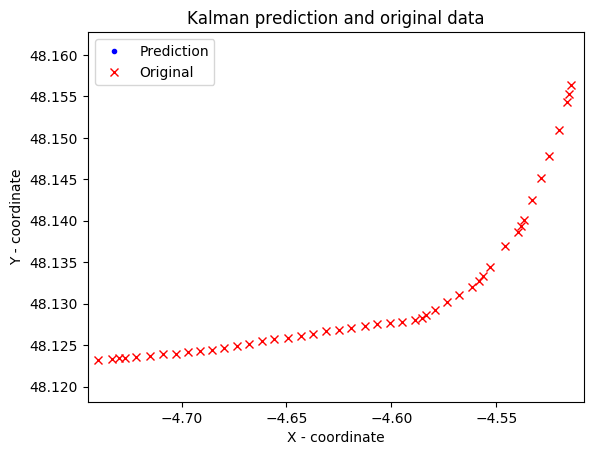

pk.val: 3e-07


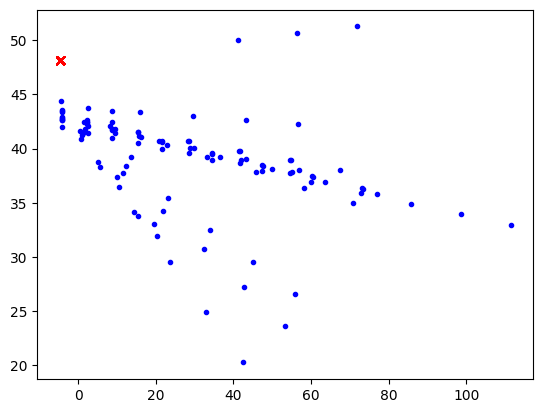

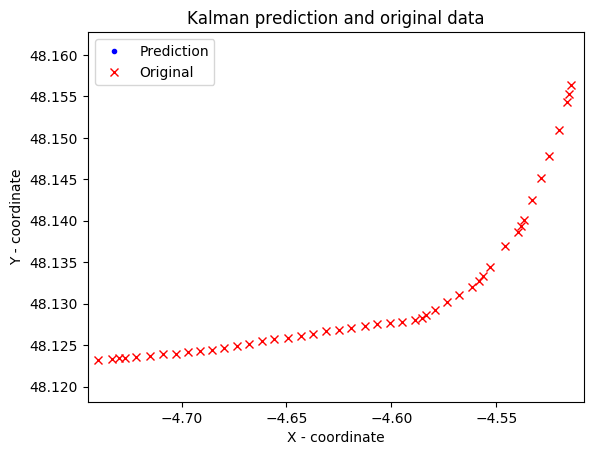

pk.val: 4e-07


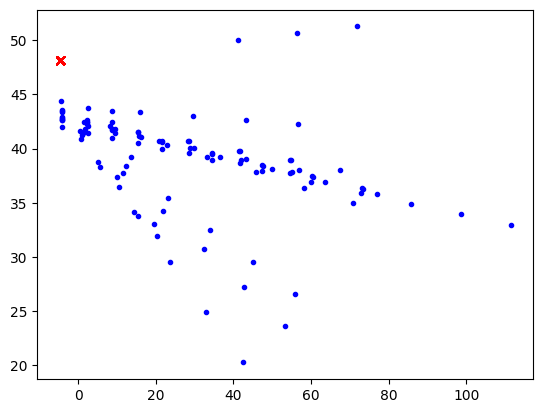

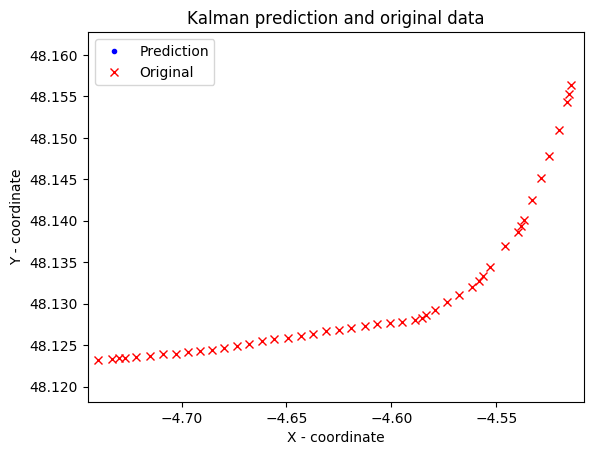

pk.val: 5e-07


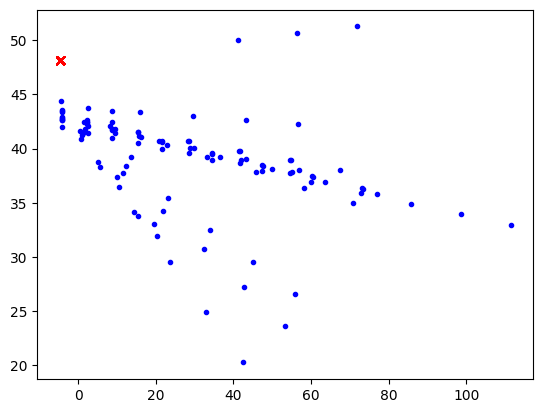

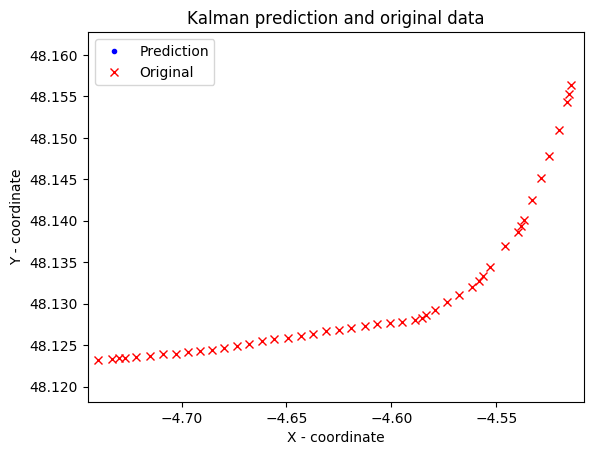

pk.val: 6e-07


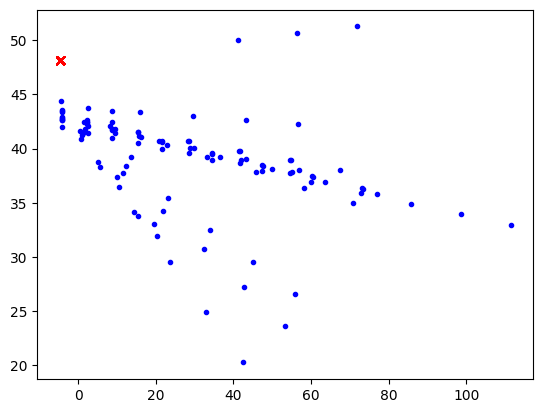

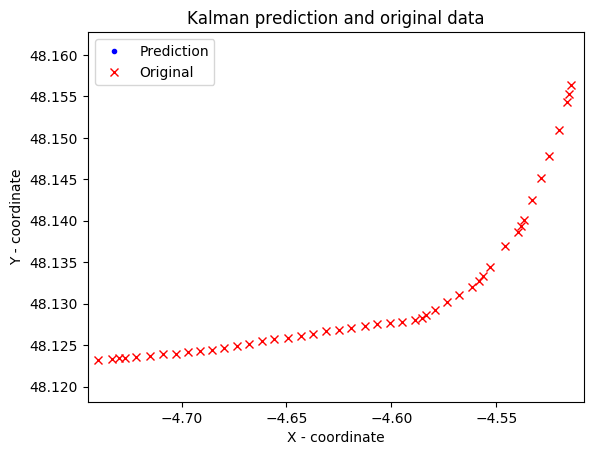

pk.val: 7e-07


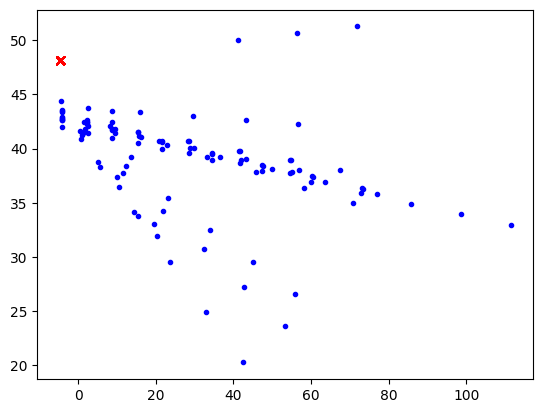

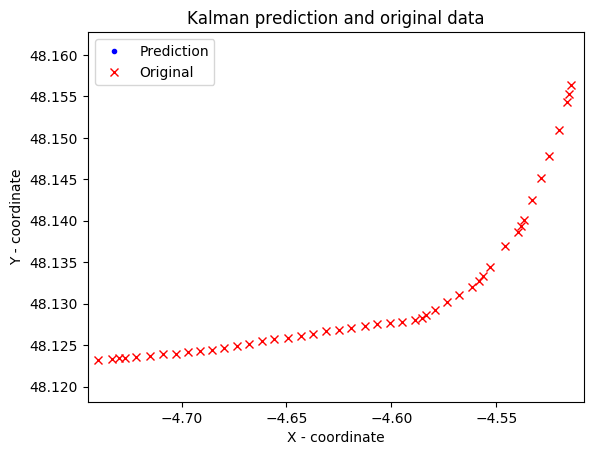

pk.val: 8e-07


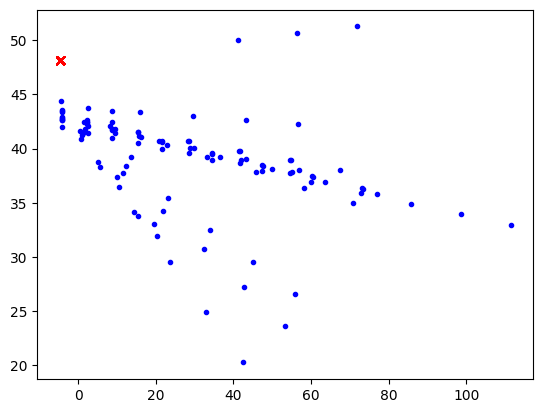

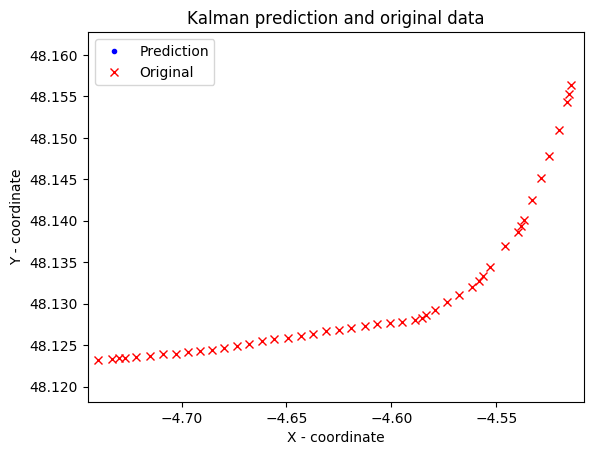

pk.val: 9e-07


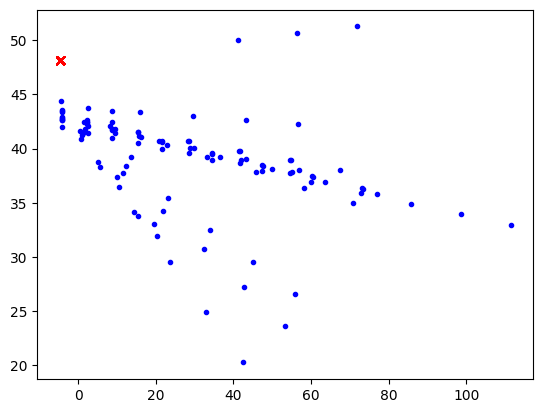

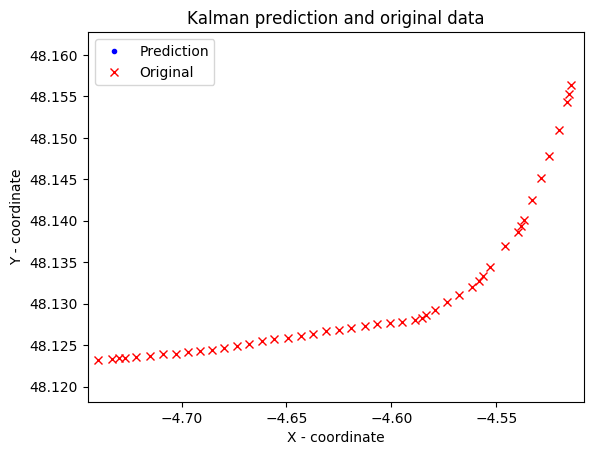

In [32]:
# Declaring the constants for Kalman filter:



for pk in np.arange(0.0000001,0.000001,0.0000001):
    print('pk.val:', pk)
    P_k = np.array([[var_lat],[var_long],[covar],[covar]]).dot(np.transpose(np.array([[var_lat],[var_long],[covar],[covar]])))
    Q = np.array([[var_lat*4],[var_long],[covar*2],[covar*2]]).dot(np.transpose(np.array([[var_lat],[var_long],[covar*2],[covar*2]])))
    R = np.diag(np.array([0.00081,0.000001,0.1,0.1]))


    data_out = discrete_subsample_data(MMSI636092331,4)

    pd_final=  copy.deepcopy(convert_dataset(data_out.reset_index(drop = True)))

    df_final = pd_final.iloc[np.arange(int(len(pd_final)*0.25),int(len(pd_final)*0.40),1),:]

    pd_final = copy.deepcopy(df_final)


    A = get_mat_A(1)
    P_k = np.array([[2],[0.0002],[0.003],[0.05]]).dot(np.transpose(np.array([[2],[0.0002],[0.003],[0.05]])))
    H = np.identity(4)
    I = np.identity(4)


    # Sensitivity measures, deep copy to avoid address pointers:
    #R = np.diag(np.array([5,5,-0.8,-0.8]))
    R = np.diag(np.array([0.0000001,0.000001,0.1,0.1]))

    #Q = copy.deepcopy(P_k)
    Q = np.array([[0.0001],[0.0001],[0.01],[0.01]]).dot(np.transpose(np.array([[0.0001],[0.0001],[0.01],[0.01]])))

    # Kalman Initial state
    X_state = np.array([[0],[0],[0],[0]])
    ax_arr = []
    ay_arr = []

    X_save_states = []
    Pk_save_states = []
    Pk_save_states.append(copy.deepcopy(P_k))

    polish_counter = 1 # counter for the original data set obsevations

    max_time = int(max(pd_final.iloc[:,0]))
    min_time = int(min(pd_final.iloc[:,0]))
    polish_counter_stop = max_time-min_time

    for i in range(min_time,(max_time)):

        '''If we observe the value we observe this'''
        if(i == 0 or (int(pd_final.iloc[polish_counter,0]) == i and polish_counter < polish_counter_stop)):
            zk_prev = pd_final.iloc[polish_counter-1,:].values
            z_k = pd_final.iloc[polish_counter,:].values # convert to numpy array -observed value

            delta_TIME = copy.deepcopy(z_k[1])
    #         print("WERK DIE" ,delta_TIME)

            ax, ay = calc_a_xy(z_k,zk_prev)
            ax_arr.append(ax)
            ay_arr.append(ay)

            z_k = copy.deepcopy(convert_state(z_k))

            X_state = copy.deepcopy(convert_state(zk_prev))
            #Kalman Predict        
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
            P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))

            # Measuremenet update
            Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
            X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
            P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))

            X_save_states.append(copy.deepcopy(X_state))

            polish_counter += 1
            Pk_save_states.append(copy.deepcopy(P_k))
            #print(z_k, '\n')
        else:
            '''This code will be excecuted when we have no observation'''
            ay = 0
            ax = 0
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
            P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))
            Pk_save_states.append(copy.deepcopy(P_k))
            X_save_states.append(copy.deepcopy(X_state))




    # Saving the coordinates:
    X_coord = []
    Y_coord = []
    Pk_coord  = []

    X_orig = pd_final.iloc[:,2]
    Y_orig = pd_final.iloc[:,3]

    for i in range(0,len(pd_final)):
        if i > 16 and  i % 2 == 0:
            X_coord.append(X_save_states[i][0][0])
            #print(X_save_states[i][0][0])
            Y_coord.append(X_save_states[i][1][0])
            Pk_coord.append(extract_long_lat_covariance(Pk_save_states[i]))


    #plt.plot(X_coord[11:380], Y_coord[11:380], "bx")
    # plt.xlim(45,48)
    # plt.ylim(-5,-4)
    plt.plot(X_orig,Y_orig,"rx")
    plt.plot(X_coord,Y_coord, "b.")
    plt.show()

    plt.plot(X_coord,Y_coord, "b.")
    plt.plot(X_orig.values[np.arange(0, len(X_orig),5)],Y_orig.values[np.arange(0, len(X_orig),5)],"rx")
    plt.title("Kalman prediction and original data")
    plt.xlabel("X - coordinate")
    plt.ylabel("Y - coordinate")
    legend_data = np.array(["Prediction","Original"])
    plt.legend(legend_data, loc = "best")

    plt.xlim(min(X_orig)-0.005, max(X_orig)+0.005,)
    plt.ylim(min(Y_orig)-0.005,max(Y_orig)+0.005,)
    plt.show()


In [17]:
print(max(pd_final.iloc[:,0]))

10387.0


In [18]:
X_plot = []
Y_plot = []

for i in subscript:
    X_plot.append(X_orig[i])
    Y_plot.append(Y_orig[i])

plt.plot(X_orig,Y_orig, "r.")
plt.show()



NameError: name 'subscript' is not defined

In [ ]:
df_sorted